In [1]:
from src.CounterfactualLoader import CounterfactualLoader
from matplotlib import pyplot as plt
import numpy as np

Simple demonstration of the Counterfactual Loader API

In [2]:
# Initialize the loader

loader = CounterfactualLoader("./data/MNIST_256.ctf")

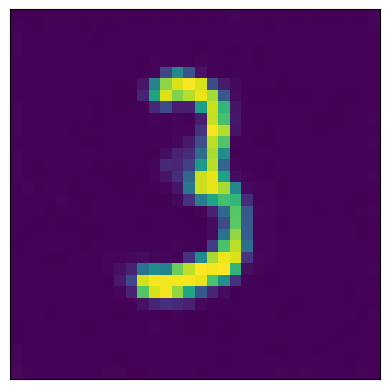

In [3]:
# Get sample 0

plt.imshow( loader.getGenerated(0) )
plt.xticks([])
plt.yticks([])
plt.show()

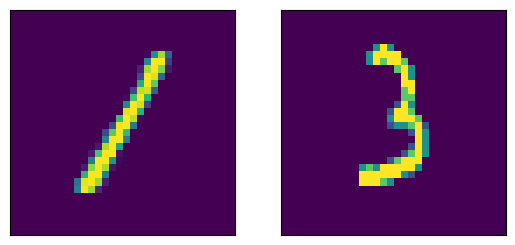

In [4]:
# Get 7th and 12th training units
# API returns a list of images belonging to the unit. For MNIST_256, units only contain single images.

_, ax = plt.subplots(1,2)
ax[0].imshow( loader.getTraining(7)[0] )
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow( loader.getTraining(12)[0] )
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

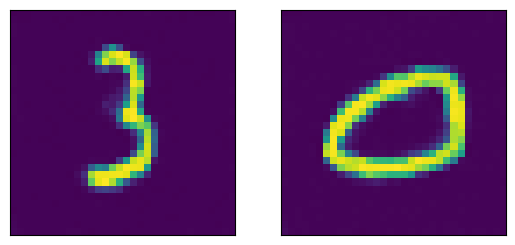

In [5]:
# Get counterfactual of 0th sample with 7th training image and 12th training image removed

_, ax = plt.subplots(1,2)
ax[0].imshow( loader.getGenerated(0, missing = 7) )
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow( loader.getGenerated(0, missing = 12) )
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

Simple algorithm for calculating Counterfactual Radius (CR)

In [6]:
# Note: images are not scaled to 256x256x3 here, distances are in native resolution

def getCounterfactualRadius(loader, sample):
    counterfactual_index = 0
    radius = 0
    factual = loader.getGenerated(sample).astype(np.float64)/255
    while True:
        try:
            counterfactual = loader.getGenerated(sample, counterfactual_index).astype(np.float64)/255
            distance = np.sum((factual - counterfactual)**2) ** 0.5
            radius = max(radius, distance)
        except:
            break
        counterfactual_index += 1
    return radius

getCounterfactualRadius(loader, 0)

9.999811609144322

Simple algorithm for calculating the False Attribution Rate (FAR) for Euclidean distance attribution

In [7]:
def SimpleAttributionWithFlips(image_raw, data):
    image = np.expand_dims(image_raw.astype(np.float64), axis = 0)
    image_flip = np.expand_dims(image_raw[:, ::-1, :].astype(np.float64), axis = 0)
    scores = []
    for training in range(data.TrainingSetSize):
        trainingImages = data.getTraining(training).astype(np.float64)
        # Get smallest squared Euclidean distance within training unit, including flips
        d = (trainingImages - image).reshape(trainingImages.shape[0], -1)
        d = np.sum(d**2, axis = 1)
        d = np.min(d)
        d_flip = (trainingImages - image_flip).reshape(trainingImages.shape[0], -1)
        d_flip = np.sum(d_flip**2, axis = 1)
        d_flip = np.min(d_flip)
        scores.append(min(d, d_flip))
    return np.argmin(scores)

def SimpleAttribution(image_raw, data, flip = True):
    image = np.expand_dims(image_raw.astype(np.float64), axis = 0)
    image_flip = np.expand_dims(image_raw[:, ::-1, :].astype(np.float64), axis = 0)
    scores = []
    for training in range(data.TrainingSetSize):
        trainingImages = data.getTraining(training).astype(np.float64)
        # Get smallest squared Euclidean distance within training unit
        d = (trainingImages - image).reshape(trainingImages.shape[0], -1)
        d = np.sum(d**2, axis = 1)
        d = np.min(d)
        scores.append(d)
    return np.argmin(scores)

def FalseAttributionTest(image_index, data, get_attribution):
    attributed_index = get_attribution(data.getGenerated(image_index), data)
    random_index = attributed_index
    while random_index == attributed_index:
        random_index = np.random.randint(data.TrainingSetSize)
    reattributed_index = get_attribution(data.getGenerated(image_index, attributed_index), data)
    reattributed_index_control = get_attribution(data.getGenerated(image_index, random_index), data)
    return attributed_index == reattributed_index, attributed_index == reattributed_index_control

def GetFAR(data, get_attribution):
    samples = data.GeneratedSetSize
    falseAttributions = []
    baselines = []
    for i in range(samples):
        isFalseAttribution, baseline = FalseAttributionTest(i, data, get_attribution)
        falseAttributions.append(1 if isFalseAttribution else 0)
        baselines.append(1 if baseline else 0)
    falseAttribution, baseline = sum(falseAttributions)/samples, sum(baselines)/samples
    trueAttributionRate = ((1-falseAttribution) - (1-baseline))/baseline
    falseAttributionRate = 1 - trueAttributionRate
    return falseAttributionRate

FAR = GetFAR(loader, SimpleAttribution)
FAR

1.1102230246251565e-16